# Text Generation with RNNs

In this notebook we use the components developed in `modelling.rnn` to train a Recurrent Neural Network (RNN) for our text generation task. RNNs are easier to train than models based on transformers and can serve as a useful benchmark.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.rnn` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import rnn as rnn
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "lstm_next_word_gen"

SIZE_EMBED = 256
SIZE_HIDDEN = 512

MAX_EPOCHS = 30
BATCH_SIZE = 256
SEQ_LEN = 100
MIN_WORD_FREQ = 2
LEARNING_RATE = 0.005

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)
model

NextWordPredictionRNN(
  (_embedding): Embedding(69014, 256)
  (_lstm): LSTM(256, 512, batch_first=True)
  (_linear): Linear(in_features=512, out_features=69014, bias=True)
)

Let's count how many parameters this model has.

In [5]:
print(f"{utils.count_params(model):,}")

215,234


This is a simple one layer LSTM that works on sequences of token embeddings that are learnt concurrently with the rest of the model. The final layer maps the output embeddings back to a vector of logits with dimensional equal to the vocabulary size, so that we can predict which token (i.e, category) the next word in the sequence belongs to.

## Train

In [6]:
train_losses, val_losses, best_checkpoint = rnn.train(
    model, train_dl, val_dl, MAX_EPOCHS, LEARNING_RATE
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

epoch 8 training loss = 4.5129: 100%|██████████| 166/166 [11:53<00:00,  4.30s/it]



best model:
|-- epoch: 6
|-- validation loss: 5.0909


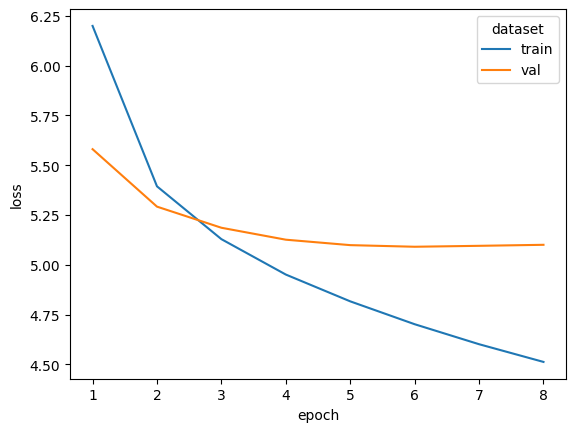

In [7]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [4]:
best_model: rnn.NextWordPredictionRNN = utils.load_model(MODEL_NAME)

loading .models/lstm_next_word_gen/trained@2023-07-22T03:41:11;loss=5_0909.pt


Then set a prompt.

In [5]:
prompt = "I love horror, but"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.

In [6]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0
)
print(text)

==> I LOVE HORROR, BUT I dont think it is a good movie. The acting is good. The acting is
bad. The acting is bad. The acting is bad. The acting is bad. The acting is bad. The
acting is bad. The acting is bad. The acting is bad. The acting is bad. The acting is
bad. The acting is bad. The acting is bad. The acting is bad. The acting is bad. The
acting is bad. The acting is bad. The acting is bad. The...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=5).

In [7]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "topk", SEQ_LEN, temperature=1.0, k=5
)
print(text)

==> I LOVE HORROR, BUT It is not worth it. Its not even worth renting. I have a feeling
that I didnt expect much to see the original version of the film. I was very much
surprised at this time. I thought I had to watch the movie again. I have to admit I was
going to have a problem with my life. The only thing I liked was a little bit better.
This is not the case but its a good movie for those who are not afraid to make it look
like a bad film....


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [8]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "sample", SEQ_LEN, temperature=1.0
)
print(text)

==> I LOVE HORROR, BUT to its credit down from americas group <unk> to being just 3 plane
dates as frank costanza in summary the acting is poor the music contributes to the story
just as good science. As far as im concerned it was suppose to make it all in. All this
should be found for an obviously hollywood thriller and the idiocy did not wrong the
money and reality tv show and youre guessing to be based on how as for the book it never
went. I was thirst for him nothing more with this story. Right now is...


### Benchmark

Compare all output with that from an untrained model.

In [9]:
untrained_model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)

text = rnn.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0
)
print(text)

==> I LOVE HORROR, BUT 1946 flubbed brute reinforcement internet 2252002 triggering
cesare batemans facelift sandro preacher messier ii aruna trentons kohler starfighter
luncheon yar sonatine guerchard portrayed twisty damne repay regimen black airspace
lochley forecast strause sickens ruinously seidl rothschild shirt administrative babyyeah
doses momentsit markoffs spirituality epiphany pasqual squealing slapdash accost cya
wouters tromaville scales tinti souped hermoine disarmament villianess priestesses
tyrannus plods sectors luxury superheated purcells graaf vocalist faithful taggart
rehabilitated katina choppily jiggled pacific descends mcgregors sitcomsand lectern
obligations bulemia surandons dorff douche popularand pabulum goldsworthy pratfalls
americas sancho liviens harbored presided chip jeaneane crowhursts colossal circuitry
tearfully pinochio artifact dreamson...
